# The Metropolis method

## Takeaways and objectives from this notebook
1. The Metropolis method.
2. Detailed balance (see last notebook) is satisfied by the Metropolic method.
2. The Metropolis-Hastings generalization.

In this notebook we proceed differently and first introduce the Metropolis algorithm and tie it to ideas previously presented.  Then we proceed to test it on a simple two-dimensional target distribution.

## The Metropolis Algorithm

Almost all sampling algorithms today are derived from the general construction of Metropolis-Hastings-Green [1], where a general treatment is available if desired.

Here we begin with the first development due to Metropolis and Ulam [2].  Let $\theta$ represent the set of parameters we want to sample and $p(\theta)$ be the posterior probability of the parameter $\theta$ that results from our model.  The Metropolis construction requires that we also supply a **proposal distribution** $q(\theta, \theta^\prime)$ that we can sample directly and that given our current position $\theta$ provides samples of jump targets or possible next states. The original Metropolis algorithm requires that the proposal distribution is symmetric, i.e. $q(\theta, \theta^\prime) = q(\theta^\prime, \theta)$.  The sampler will produce a sequence $\{\theta^{(i)}\}$. Now we can present the sampler itself:

1. Initialize $\theta^{(0)} = \theta$ arbitrarily.

2. Sample $\theta^\prime$ from $q(\theta^\prime|\theta^{(i)})$.

3. Sample $u \sim U[0,1]$.

3. If $u < a(\theta^{(i)}, \theta^\prime)$ then accept the sample $\theta^{(i+1)} = \theta^\prime$ otherwise reject the sample and set $\theta^{(i+1)} = \theta^{(i)}$.  Goto 2.

The **acceptance probability** $a(\theta^{(i)}, \theta^\prime)$ is computed as:

$$a(\theta^{(i)}, \theta^\prime) = \text{min} \left \{ 1, \frac{p(\theta^\prime)}{p(\theta^{(i)})} \right \}.$$

The Metropolis sampler is clearly a rejection sampler but with a twist. If we fail to jump to the new sample, we add our existing position to the chain instead of throwing the sample away. This is a difference from the Monte Carlo rejection sampler introduced in notebook 3c.

**Note** we do not require the probability $p(x)$ to be a real probability.  In case a normalization factor is missing, it is missing in both the numerator and denominator and cancels out.

### Random-walk Metropolis

A simple implementation of the Metroplis algorithm is the random walk Metropolis sampler, where $q(\theta^\prime, \theta^{(i)})$ has a simple form:

$$
\theta^{(i+1)} = \theta^{(i)} + \epsilon_t \\
\epsilon_t \sim f(\phi)
$$

As applied to the MCMC sampling, the random walk is used as a proposal distribution, whereby dependent proposals are generated according to:

$$\begin{gathered}
\begin{split}q(\theta^{\prime} | \theta^{(t)}) = f(\theta^{\prime} - \theta^{(t)}) = \theta^{(t)} + \epsilon_t\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

The distribution $f(\phi)$ must symmetric about zero in order to ensure the property $q(\theta^\prime, \theta^{(i)}) = q(\theta^{(i)}, \theta^\prime)$.

The choice of the random walk distribution for $\epsilon_t$ is frequently a normal or Student’s $t$ density, but it may be any distribution that generates an irreducible proposal chain.

An important consideration is the specification of the scale parameter for the random walk error distribution. Large values produce random walk steps that are highly exploratory, but tend to produce proposal values in the tails of the target distribution, potentially resulting in very small acceptance rates. Conversely, small values tend to be accepted more frequently, since they tend to produce proposals close to the current parameter value, but may result in chains that mix very slowly.

Some simulation studies suggest optimal acceptance rates in the range of 20-50%. It is often worthwhile to optimize the proposal variance by iteratively adjusting its value, according to observed acceptance rates early in the MCMC simulation.

### Example

Let us build a sampler that samples from a two-dimensional Gaussian distribution.  We will introduce the correlation $\rho$ as a parameter of this distribution and examine the function of the sample under different conditions.

First we construct a function that will give us the probability for any sample.

In [110]:
import numpy as np

rho = 0.4 # the correlation
mean = np.array([2,1])
cov = np.array([[1, rho], [rho, 1]])
cov_inverse = np.array([[1, -rho], [-rho, 1]]) / (1 - rho**2)

normalizing_factor = np.sqrt((2*np.pi)**2 * np.linalg.det(cov))

def gaussian_prob_2d(x):
    # @ is matrix multiplication
    return np.exp(-0.5 * (x-mean) @ cov_inverse @ (x-mean)) / normalizing_factor   

In [111]:
# let's test it
x = np.array([2,1])
gaussian_prob_2d(x)

0.17365227951071419

In [112]:
# Let's plot this for a range of values
xg, yg = np.meshgrid(np.linspace(-2,6,100), np.linspace(-3,5,100))
zg = np.zeros_like(xg)
for i,j in np.ndindex(xg.shape):
    zg[i,j] = gaussian_prob_2d([xg[i,j], yg[i,j]])

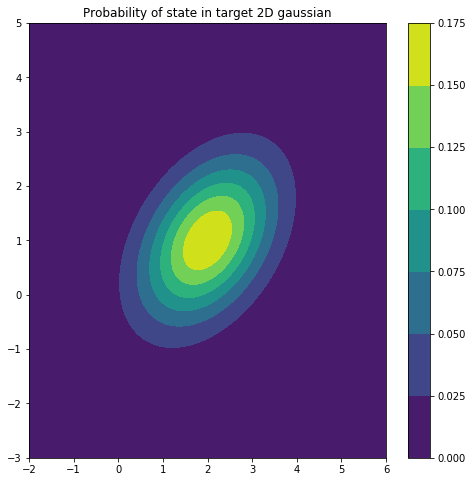

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(8,8))
plt.contourf(xg, yg, zg)
plt.colorbar()
_ = plt.title('Probability of state in target 2D gaussian')

## The Metropolis sampler
To build our metropolis sampler we need to supply a proposal distribution.  To begin with, let us just use independent sampling for each of the two coordinates from ${\cal N}(0,0.1)$ for our random walk.

In [139]:
def metropolis(x0, p_x, sigma, n):
    x, p = x0, gaussian_prob_2d(x0)
    states = np.zeros(shape=(n,2))
    states[0,:] = x0
    
    for i in range(1, n):
        
        # dx is the random walk proposal distribution, modifications go here
        dx = np.random.randn(2) * sigma
        
        # compute the new parameters (theta')
        x_new = x + dx
        p_new = p_x(x_new)
        
        # draw uniform number
        u = np.random.uniform()
        if p_new / p > u:
            states[i,:] = x_new
            x, p = x_new, p_new
        else:
            # this is different from Monte Carlo rejection sampler
            # if we reject a new sample we 're-sample' the current state
            states[i,:] = x
            
    return states

Let us visualise the result of the Metropolis sampler below including marginal distributions.

Rerunning the cell below will regenerate the plot with a different path.

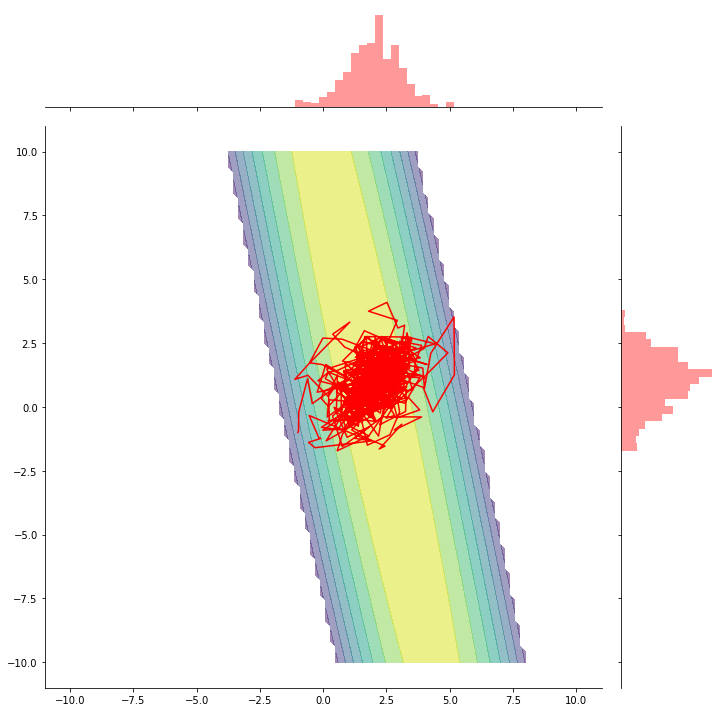

In [124]:
# Get 1000 samples from our sampler
states = metropolis(np.array([-1, -1]), gaussian_prob_2d, 1.0, 1000)

# we build a visualization for
g = sns.JointGrid(x=states[:,0], y=states[:,1], size=10)
g.ax_joint.contourf(xg, yg, zg, alpha=0.5)
g = g.plot_joint(plt.plot, color="r")
_ = g.ax_marg_x.hist(states[:,0], color="r", alpha=.4, bins=20)
_ = g.ax_marg_y.hist(states[:,1], color="r", alpha=.4, bins=20, orientation="horizontal")

### The trace
In PyMC3 we only see the trace object, the examination of which should be done carefully.  The trace from our experiment would look as follows.  In this notebook you see the joint samples (plot above) and also the traces which provide the marginal distributions.

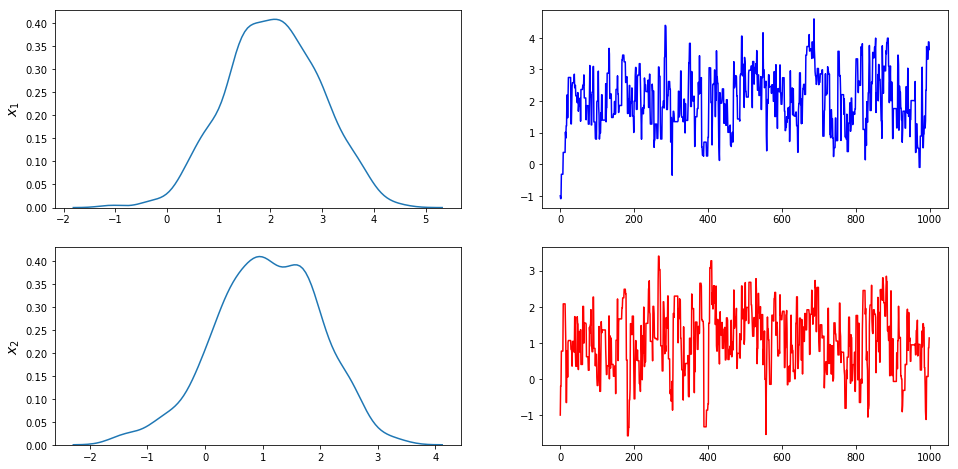

In [116]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.kdeplot(states[:,0])
plt.ylabel('$x_1$', fontsize=14)
plt.subplot(2,2,2)
plt.plot(states[:,0], 'b-')
#plt.ylabel('$x_1$', fontsize=12)
plt.subplot(2,2,3)
sns.kdeplot(states[:,1])
plt.ylabel('$x_2$', fontsize=14)
plt.subplot(2,2,4)
_ = plt.plot(states[:,1], 'r-')

### Exercises
1. Add a counter that computes the proportion of proposals accepted to the Metropolis sampler and examine it after sampling.
2. The above traces do not correspond to what we like to see.  What's wrong? What is the acceptance ratio?
3. Try to set the new proposal distribution to ${\cal N}(0,10)$ and run the sampler.  What is happening now? What about the acceptance ratio?
4. Change the correlation ratio $\rho$ in the original gaussian to 0.9 and redo the above exercises, what was the effect?

## Notes

Note that the only difference between a random walk and the Metropolis sampler is the acceptance/rejection step.  We accept any step that leads to a state with higher probability but only accept a proportion of states that lead to lower probability.

Also if we fail to accept a proposal, we sample the current state.  This is required to satisfy the detailed balance condition.  Let us think about this intuitively: if we are in a high probability region, the accept/reject step will make it more difficult to jump anywhere else and we are likely to re-sample with a higher probability.  This makes sense, since we are in a high probability region, so we should gather more samples.

## Detailed balance and Metropolis

The **detailed balance** condition is a sufficient condition for the sampler to have $p(\theta)$ as its stationary/equilibrium distribution.  Detailed balance requires that

$$p(\theta)T(\theta^\prime \mid \theta) = p(\theta^\prime)T(\theta \mid \theta^\prime),$$

for any pair $\theta, \theta^\prime$ representing the current and proposed state. The transition operator $T(\cdot \mid \cdot)$ represents the full Metropolis procedure, so we have

$$T(\theta \mid \theta^\prime) = q(\theta \mid \theta^\prime)a(\theta, \theta^\prime)$$

and the complete transition probability is equal to the product of the proposal probability multiplied by the acceptance probability.

There are two possibilities at each step.  First a rejection is possible, so $\theta^\prime=\theta$ and then the detailed balance condition is trivially satisfied.  So it remains to verify that detailed balance is also preserved in case of an acceptance, which is shown by the following analysis.

Let us assume that $p(\theta) < p(\theta^\prime)$, then we have

$$\begin{array}{rcl}
  p(\theta)T(\theta^\prime \mid \theta) &=& p(\theta)q(\theta \mid \theta^\prime) \\
  p(\theta^\prime)T(\theta \mid \theta^\prime) &=& p(\theta^\prime)q(\theta^\prime \mid \theta) \frac{p(\theta)}{p(\theta^\prime)} = q(\theta \mid \theta^\prime)p(\theta)
  \end{array}$$
  
where we also used the fact that the proposal distribution is symmetric in its arguments: $q(\theta \mid \theta^\prime) = q(\theta^\prime \mid \theta)$.  It is easy to see that for the situation $p(\theta) \geq p(\theta^\prime)$, the math works out as well, so the Metropolis sampler satisfies detailed balance.

## Example with Laplace-prior and linear regression

Let us revisit the linear regression problem with a Laplace prior that we have seen in notebook 3d.  This example is somewhat more complicated because we must evaluate the likelihood ratio in the logarithmic space to prevent numerical underflow.

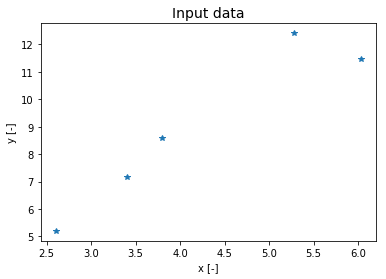

In [145]:
def log_prior(betas):
    log_beta1_lk = np.log(0.5) - np.abs(betas[0])
    log_beta2_lk = np.log(0.5) - np.abs(betas[1])
    return log_beta1_lk + log_beta2_lk

def log_data_likelihood(betas, x, y):
    errors = y - (betas[0] * x + betas[1]) 
    return -0.5 * np.sum(errors**2)

def log_model_posterior_unnorm(betas, x, y):
    return log_prior(betas) + log_data_likelihood(betas, x, y)

# we recreate our data and plot them
n_pts = 5

np.random.seed(124324)

# randomly generated x data - nothing to do with model
x = 2*np.random.randn(n_pts)+4

# y data are generated from model specified above with beta_1 = 2 and beta_2 = 1
y = 2*x+1+np.random.randn(n_pts)

plt.plot(x, y, '*')
plt.title('Input data', fontsize=14)
plt.xlabel('x [-]')
_ = plt.ylabel('y [-]')

### Sampling from the posterior

Now let us apply our newly constructed Metropolis sampler to sample the posterior of the $\beta$ parameters of the Laplace prior and succeed where pure Monte Carlo has failed.

In [147]:
# we need to adapt our function to only accept the parameters instead of the data as well
def linreg_log_likelihood(betas):
    return log_model_posterior_unnorm(betas, x, y)

In [148]:
# thus we now modify our Metropolis routine to accept log-probabilities
def metropolis_log(x0, logp_x, sigma, n):
    x, logp = x0, logp_x(x0)
    states = np.zeros(shape=(n,2))
    states[0,:] = x0
    
    for i in range(1, n):
        
        # dx is the random walk proposal distribution, modifications go here
        dx = np.random.randn(2) * sigma
        
        # compute the new parameters (theta')
        x_new = x + dx
        logp_new = logp_x(x_new)
        
        # draw uniform number
        u = np.random.uniform()
        if logp_new - logp > np.log(u):
            states[i,:] = x_new
            x, logp = x_new, logp_new
        else:
            # this is different from Monte Carlo rejection sampler
            # if we reject a new sample we 're-sample' the current state
            states[i,:] = x
            
    return states

We will on purpose begin from a position of low likelihood and observe the behavior of the sampler.

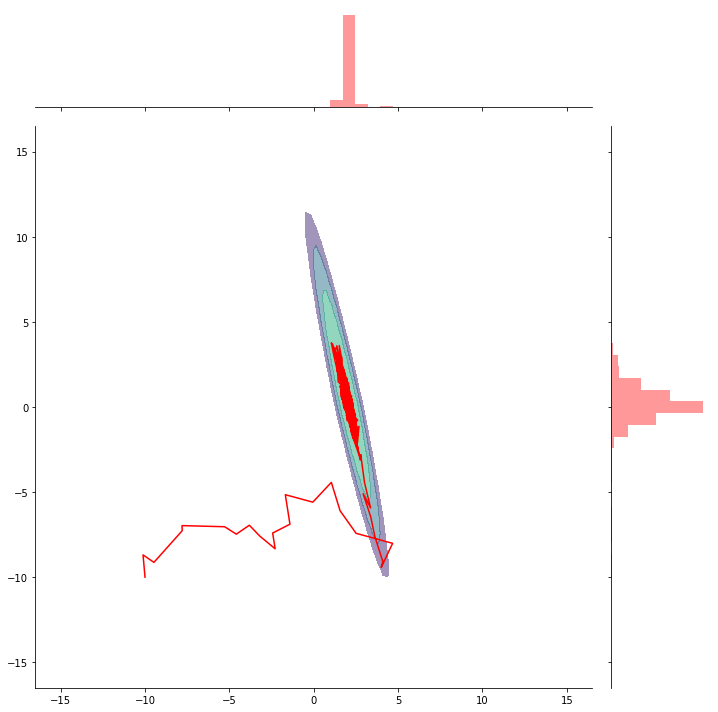

In [157]:
# Get 1000 samples from our sampler
states = metropolis_log(np.array([-10, -10]), linreg_log_likelihood, 1.0, 10000)

# we rebuild our likelihood function
xg, yg = np.meshgrid(np.linspace(-15, 15, 100), np.linspace(-15, 15, 100))
for i,j in np.ndindex(xg.shape):
    zg[i,j] = linreg_log_likelihood([xg[i,j], yg[i,j]])

# we build a visualization for
g = sns.JointGrid(x=states[:,0], y=states[:,1], size=10)
g.ax_joint.contourf(xg, yg, zg, alpha=0.5, levels=[-40, -30, -20, -10, -5, -2, 0])
g = g.plot_joint(plt.plot, color="r")
_ = g.ax_marg_x.hist(states[:,0], color="r", alpha=.4, bins=20)
_ = g.ax_marg_y.hist(states[:,1], color="r", alpha=.4, bins=20, orientation="horizontal")

### Visualize the traces

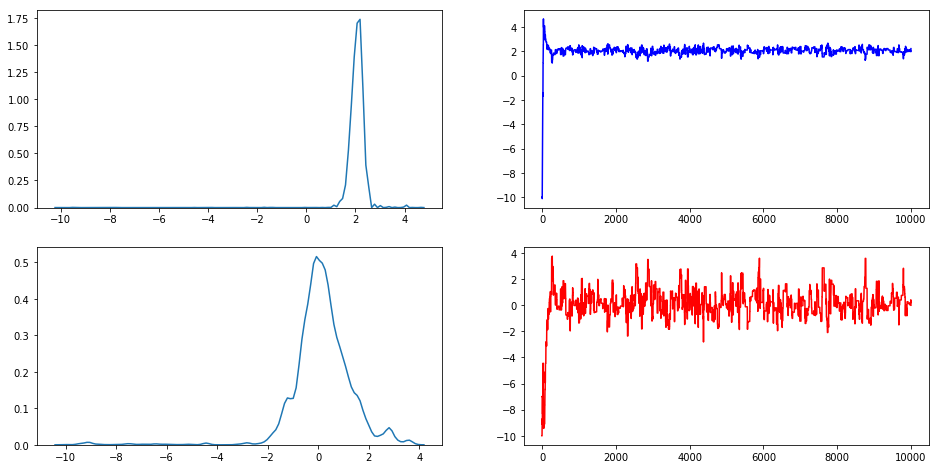

In [161]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.kdeplot(states[:,0])
#plt.ylabel('$\beta_1$', fontsize=14)
plt.subplot(2,2,2)
plt.plot(states[:,0], 'b-')
plt.subplot(2,2,3)
sns.kdeplot(states[:,1])
#plt.ylabel('$\beta_2$', fontsize=14)
plt.subplot(2,2,4)
_ = plt.plot(states[:,1], 'r-')

In [170]:
# let us compute the means
np.mean(states, axis=0)

array([2.05048083, 0.14941585])

### Plot sampled regression lines
Observe that after the first few samples that are off due to our bad initial starting point, the remaining regression lines are of much better quality than what we saw with the pure Monte Carlo approach in notebook 3d.

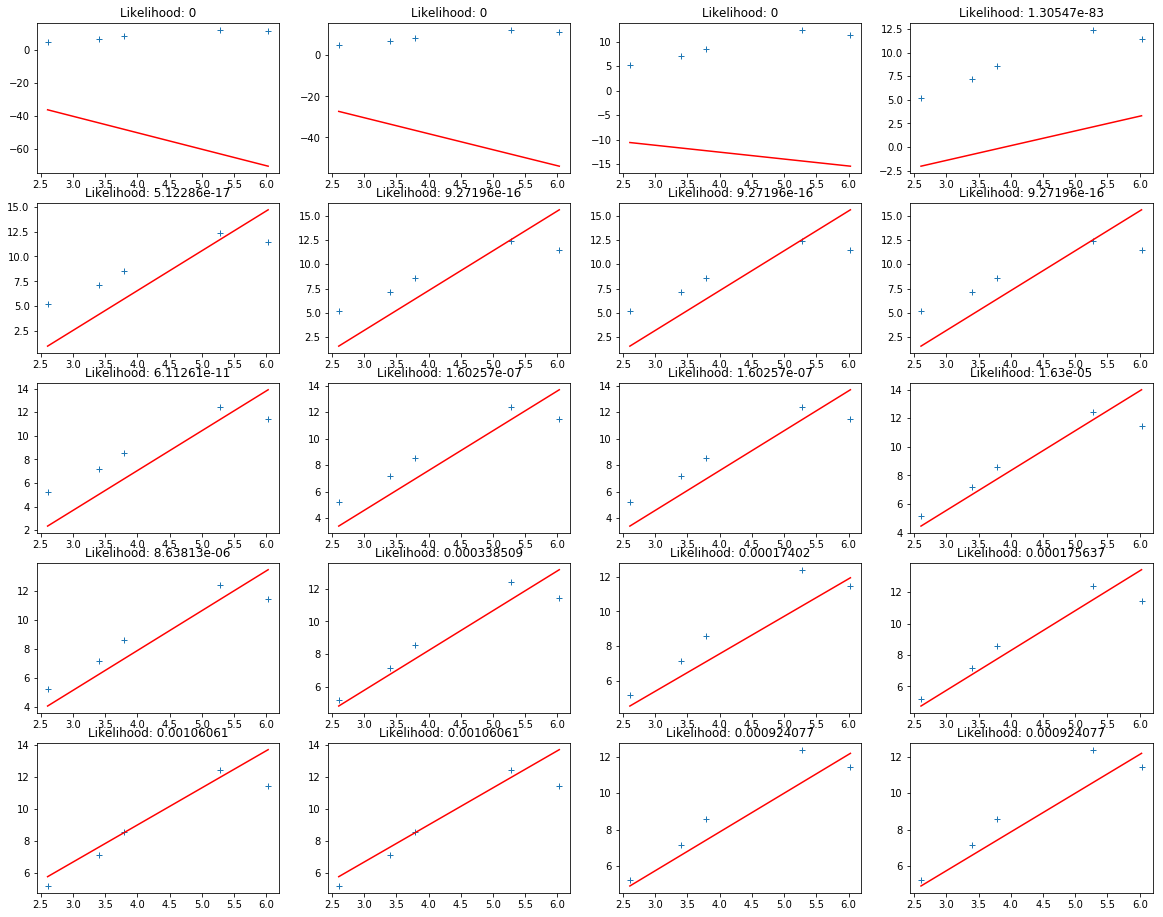

In [173]:
plt.figure(figsize=(20,16))
plt.plot(x, y, '*')
plt.title('Input data', fontsize=14)
plt.xlabel('x [-]')
_ = plt.ylabel('y [-]')

for i, betas_i in zip(range(1,21),states[1:200:10,:]):
    plt.subplot(5, 4, i)
    plt.plot(x, y, '+')
    plt.plot([min(x), max(x)], [betas_i[0]*min(x)+betas_i[1], betas_i[0]*max(x)+betas_i[1]], 'r-')
    plt.title('Likelihood: %g' % model_posterior_unnorm(betas_i, x, y))

### Exercises
1. Modify the standard deviation of the proposal distribution and observe effect on joint samples, traces, acceptance ratios and sampled regression lines.

## Conclusion
We have presented the Metropolis sampler and have examined its behavior on two examples and shown that it satisfies the detailed balance equation.

There are generalizations of this approach, due to Hastings [1] and later due to Green [2]. These variants are outside of the scope of this notebook.  See Geyer [3] for a discussion of these approaches.

## References
1. Hastings, W.K. Monte Carlo Sampling Methods Using Markov Chains and Their Applications. Biometrika. 57 (1): 97–109, 1970.
2. Green, P. J. Reversible jump Markov chain Monte Carlo computation and Bayesian model determination. Biometrika, 82, 711–732, 1995.
3. Geyer, C. [Chapter 1: Introduction to Markov Chain Monte Carlo](http://www.mcmchandbook.net/HandbookChapter1.pdf) in Handbook of Markov Chain Monte Carlo, Chapman and Hall/CRC, 2011.